In [0]:
#Connection with Google Drive

#from google.colab import drive
#drive.mount('/content/gdrive')
#!cp -rv /content/train_processed.zip /content/gdrive/My\ Drive/train_processed.zip
#!rm /content/gdrive/My\ Drive/kaggle_data/train_processed.zip
#!cp -rv /content/gdrive/My\ Drive/train_processed.zip /content/gdrive/My\ Drive/kaggle_data/train_processed.zip

# Connecting with Kaggle and Storing Data locally

In [40]:
# Get data from Kaggle
!pip install kaggle
!mkdir ~/.kaggle
!mkdir /content/.kaggle
!ls ~/.kaggle

import json
token = {"username":"mielgosez", "key":"46ef90eb86d527d54aca090759ccbef9"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

print("1. Downloading datasets")
!kaggle competitions download -c histopathologic-cancer-detection -p /content/

print("2.  Moving train set to train folder")
!mkdir /content/train
!unzip -qq /content/train.zip -d /content/train
print("3. Moving test set to test folder")
!mkdir /content/test
!unzip -qq /content/test.zip -d /content/test


print("4. Moving files to their corresponding folders")
!mkdir /content/train/0
!mkdir /content/train/1
import pandas as pd
import shutil
!unzip -qq /content/train_labels.csv.zip
file_assign = pd.read_csv("/content/train_labels.csv") 
file_assign = file_assign.values
for item in file_assign:
  if item[1] == 0:
    shutil.move("/content/train/"+item[0]+".tif", 
                "/content/train/0/"+item[0]+".tif")
  else:
    shutil.move("/content/train/"+item[0]+".tif", 
                "/content/train/1/"+item[0]+".tif")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘/content/.kaggle’: File exists
kaggle.json
- path is now set to: {/content}
1. Downloading datasets
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
2.  Moving train set to train folder
mkdir: cannot create directory ‘/content/train’: File exists
3. Moving test set to test folder
mkdir: cannot create directory ‘/content/test’: File exists
replace /content/test/dbc7573e5b13d8aab1d8a6ef4bf0bda404505f46.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/test/c347a27c7da7f1549e2af34e22a4a151b2afb359.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
4.

In [41]:
# Verify that the 
import os
path, dirs, files = next(os.walk("/content/train/0"))
file_count = len(files)
print("Number of files in train folder cat 0:"+ str(file_count))

path, dirs, files = next(os.walk("/content/train/1"))
file_count = len(files)
print("Number of files in train folder cat 1:"+ str(file_count))

Number of files in train folder cat 0:130908
Number of files in train folder cat 1:89117


# Creating the Sequential Model

In [42]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/train"
test_dir = "/content/test"

# Parameters
image_size = 96
batch_size = 32


# Data Setting

general_datagen = ImageDataGenerator(
        preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

# Aquí dejar la mariquera y poner todo boolean
train_generator = general_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='binary',
        subset='training')

validation_generator = general_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')

Found 176021 images belonging to 2 classes.
Found 44004 images belonging to 2 classes.


In [43]:
from PIL import Image
import pandas as pd

file_assign = pd.read_csv("/content/train_labels.csv") 
file_assign = file_assign.values

image_sizes = []
for item in file_assign:
  if item[1] == 0:
    im = Image.open("/content/test/"+item[0]+".tif")
  else:
    im = Image.open("/content/train/1/"+item[0]+".tif")
  image_sizes.append(im.size)

FileNotFoundError: ignored

In [44]:
ps = pd.Series([tuple(i) for i in image_sizes])
counts = ps.value_counts()
print(counts)

Series([], dtype: int64)


In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

# Use sigmoid and binary cross-entropy to address the problem in a more accurate fashion.
# Another trick is to increase the kernel size to track 'bigger' details
# Batch normalization is:
# 
model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (image_size, image_size, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_3 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 44, 44, 64)        18432     
__________

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
import numpy as np

# 176021 and 44004 are the sizes provided in the bloc where train_generator
# and validation_generator were defined.
train_steps = np.ceil(176021 / batch_size)
val_steps = np.ceil(44004 / batch_size)

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, 
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    epochs=6,
                    callbacks=[reducel, earlystopper, tbCallBack])

Epoch 1/6
5501/5501 [==============================] - 2087s 379ms/step - loss: 0.3953 - acc: 0.8284 - val_loss: 0.3245 - val_acc: 0.8550
Epoch 2/6
5501/5501 [==============================] - 2012s 366ms/step - loss: 0.2969 - acc: 0.8802 - val_loss: 0.2494 - val_acc: 0.8948
Epoch 3/6
5501/5501 [==============================] - 2001s 364ms/step - loss: 0.2638 - acc: 0.8962 - val_loss: 0.2930 - val_acc: 0.8738

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/6
5107/5501 [==========================>...] - ETA: 2:11 - loss: 0.2175 - acc: 0.9176

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
!ls /content/test/ | wc -l
!unzip -qq /content/test.zip -d /content/test/test
test_generator = test_datagen.flow_from_directory(
        "/content/test/",
        target_size=(image_size, image_size),
        color_mode="rgb",
        batch_size=1,
        class_mode=None,
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples, verbose=1)

57458
Found 57458 images belonging to 1 classes.


# Generating the report on Test data

In [0]:
from glob import glob
import os
from skimage.io import imread

base_test_dir = '/content/test/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print(max_idx)
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()


57458
Indexes: 0 - 5000
57458
Indexes: 5000 - 10000
57458
Indexes: 10000 - 15000
57458
Indexes: 15000 - 20000
57458
Indexes: 20000 - 25000
57458
Indexes: 25000 - 30000
57458
Indexes: 30000 - 35000
57458
Indexes: 35000 - 40000
57458
Indexes: 40000 - 45000
57458
Indexes: 45000 - 50000
57458
Indexes: 50000 - 55000
57458
Indexes: 55000 - 60000


,id,label
0,b8c53202df10b76794c1daa23e8997e0ac9a6f94,0.237784
1,3a4c4b99fbff710accb62d5fa480d131e57845a5,0.053820
2,a98ab9e399ef57531448592c725bb6141dfb83e6,0.050331
3,45732e8cfd8d42b1fd1f97feaf748d3ba3e36474,0.013040
4,4eefeedfcc99914ee4ecb32bedfa93c19884d702,0.007161


Results are submitted to Kaggle

In [0]:
submission.to_csv("results.csv",index=False)
!kaggle competitions submit -c histopathologic-cancer-detection -f results.csv -m "2nd attempt"

100% 2.87M/2.87M [00:07<00:00, 407kB/s]
Successfully submitted to Histopathologic Cancer Detection

Accuracy: 0.9044

# Visualizing kernels

Source: https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

In [0]:
from keras.models import load_model
model = load_model('model.h5')

1.2.0
Ready layer id
Ready activation
Ready model modification
Generate Image


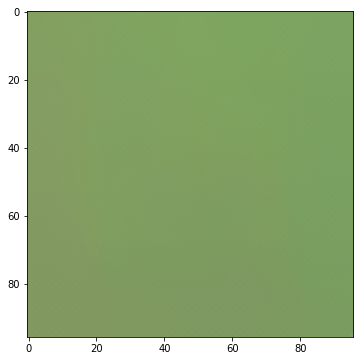

In [6]:
#!pip install Pillow
#!pip install vis
#!pip install scipy==1.2.0
#!pip uninstall vis
#!pip uninstall keras-vis
#!pip uninstall keras-vis-temp
#!pip install git+https://github.com/raghakot/keras-vis.git -U

import scipy
print(scipy.__version__)
from scipy.misc import imresize
#importing the required modules
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from keras import applications
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,6)
layer_idx = utils.find_layer_idx(model,'dense_2')
print("Ready layer id")
#changing the activation of the layer to linear
model.layers[layer_idx].activation = activations.linear
print("Ready activation")
#applying modifications to the model
model = utils.apply_modifications(model)
print("Ready model modification")
#Indian elephant
img3 = visualize_activation(model,layer_idx,max_iter=5000,verbose=False)
print("Generate Image")
plt.imshow(img3)

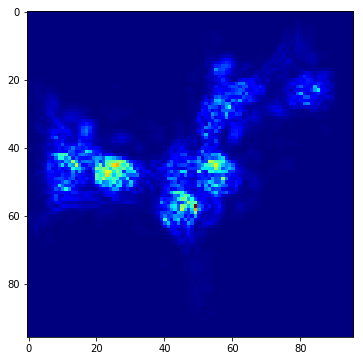

In [29]:
from vis.visualization import visualize_saliency
x,y = train_generator.next()
image = x[10,:,:,:]
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

#generating saliency map with unguided backprop
grads1 = visualize_saliency(model, layer_idx,filter_indices=None,seed_input=image)
#plotting the unguided saliency map
plt.imshow(grads1,cmap='jet')

grads2 =  visualize_saliency(model, layer_idx,filter_indices=None,seed_input=image,backprop_modifier='guided')
#plotting the saliency map as heatmap
plt.imshow(grads2,cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


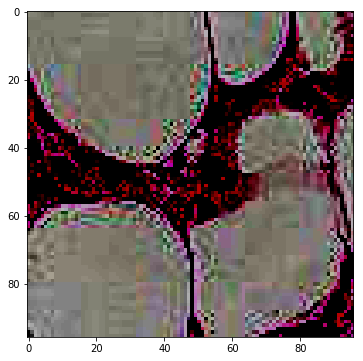

In [30]:
plt.imshow(image)

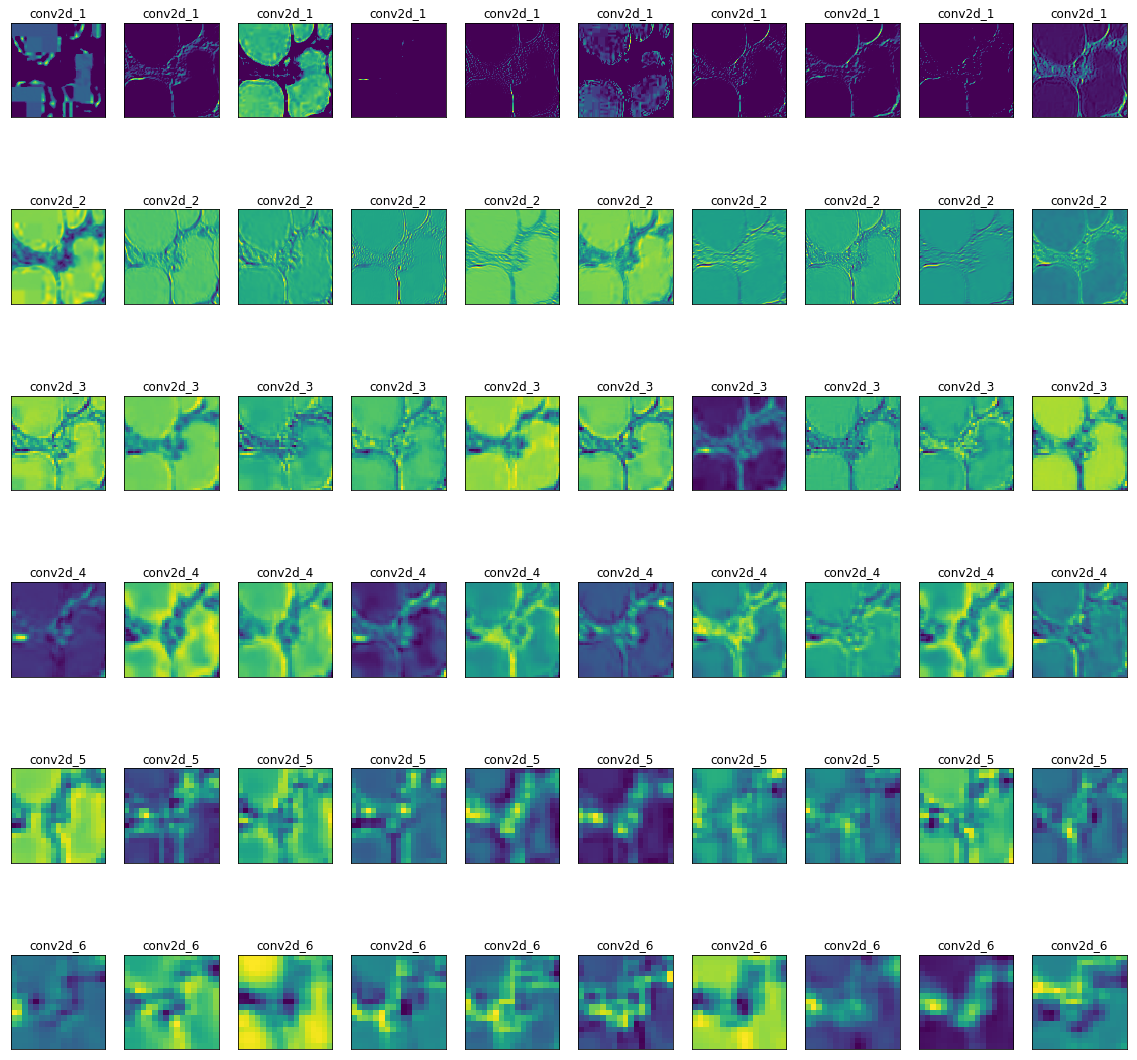

In [32]:
image = x[10,:,:,:]
#importing required libraries and functions
from keras.models import Model
#defining names of layers from which we will take the output
layer_names = ['conv2d_1','conv2d_2','conv2d_3','conv2d_4', 'conv2d_5','conv2d_6']
outputs = []
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#extracting the output and appending to outputs
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(image)
    outputs.append(intermediate_output)
#plotting the outputs
fig,ax = plt.subplots(nrows=6,ncols=10,figsize=(20,20))

for i in range(6):
    for z in range(10):
        ax[i][z].imshow(outputs[i][0,:,:,z])
        ax[i][z].set_title(layer_names[i])
        ax[i][z].set_xticks([])
        ax[i][z].set_yticks([])
plt.savefig('layerwise_output.jpg')

In [38]:
!tensorboard --logdir='/content/'

TensorBoard 1.13.1 at http://94a3a72ec782:6006 (Press CTRL+C to quit)
^C
